In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, ElasticNetCV
from sklearn.metrics import mean_squared_error

from mlxtend.feature_selection import SequentialFeatureSelector

In [2]:
ames_df = pd.read_csv('../datasets/ames_df_explored.csv')

In [3]:
ames_test = pd.read_csv('../datasets/ames_test_explored.csv')

In [25]:
pd.set_option('display.max_columns',None)

## Section 6: Feature Selection and Using Linear Regression, Ridge, and Lasso to Predict

After exploring the data, I use the Stepwise Selection algorithm ot pick the best features. Stepwise works by starting with zero features and adding features one by one to find the optimal features to use. 

At this point, I will split the data into training and testing sets so that I don't clean the test data

In [4]:
#Using train_test_split to create training and test sets. Set a random seed for reproducibility
X = ames_df.loc[:,ames_df.columns != 'saleprice']
y = ames_df['saleprice']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)

Scale the data with StandardScaler, to ensure that the features are compared on an even footing

In [5]:
#Scale the data using StandardScaler()
ames_ss = StandardScaler()

ames_ss.fit(X_train)

X_train_ss = ames_ss.transform(X_train)
X_test_ss = ames_ss.transform(X_test)
ames_test_ss = ames_ss.transform(ames_test)

In [6]:
#Linking the transformed data with the feature names by creating a separate dataframe
transformed_X_train = pd.DataFrame(data=X_train_ss, columns= X_train.columns)

In [7]:
#Making sure the dataframe is created properly
transformed_X_train.head(1)

,Unnamed: 0,Unnamed: 0.1,ms_subclass,lot_frontage,lot_area,lot_shape,utilities,land_slope,overall_qual,overall_cond,...,garage_type_CarPort,garage_type_Detchd,sale_type_CWD,sale_type_Con,sale_type_ConLD,sale_type_ConLI,sale_type_ConLw,sale_type_New,sale_type_Oth,sale_type_WD
0,-1.036852,-1.036852,0.322826,1.847527,0.531987,0.720483,0.0,0.223345,0.62824,2.165189,...,-0.057148,-0.598406,-0.067662,-0.036108,-0.092389,-0.025524,-0.057148,-0.288471,-0.051098,0.389133


Using Stepwise Selection to pick the best features. I will use the implementation from the library Machine Learning Extensions: [mlxtend](https://github.com/rasbt/mlxtend/)

In [8]:
#Instantiate linear regression for use in Sequential Feature Selection
ames_lr = LinearRegression()

In [9]:
#Do Sequential Feature Selector with the Linear Regression model to pick the best k features,
#with k between 30-40, after selection was tested with 1-100. 
ames_sfs = SequentialFeatureSelector(estimator=ames_lr, k_features=(10,30), forward=True, 
                                     scoring='neg_root_mean_squared_error')

In [10]:
ames_sfs.fit(transformed_X_train, y_train)

SequentialFeatureSelector(estimator=LinearRegression(), k_features=(10, 30),
                          scoring='neg_root_mean_squared_error')

In [11]:
#Printing the best score found by the Sequential Feature Selector and the feature names
print(f"The best score is: {ames_sfs.k_score_}, \n\nAchieved using these features: {ames_sfs.k_feature_names_}")

The best score is: -24073.60555382976, 

Achieved using these features: ('ms_subclass', 'lot_area', 'overall_qual', 'overall_cond', 'year_built', 'mas_vnr_area', 'exter_qual', 'bsmt_qual', 'bsmt_exposure', 'bsmtfin_sf_1', 'total_bsmt_sf', 'gr_liv_area', 'bedroom_abvgr', 'kitchen_qual', 'functional', 'screen_porch', 'land_contour_HLS', 'neighborhood_BrkSide', 'neighborhood_Crawfor', 'neighborhood_NoRidge', 'neighborhood_NridgHt', 'neighborhood_StoneBr', 'condition_1_Norm', 'condition_1_PosN', 'condition_2_PosA', 'roof_style_Hip', 'exterior_1st_BrkFace', 'mas_vnr_type_BrkFace', 'garage_type_Attchd', 'sale_type_New')


In [12]:
#Saving the feature names into a list
features_to_use = list(ames_sfs.k_feature_names_)
print(f"There are a total of {len(ames_sfs.k_feature_names_)} features")

There are a total of 30 features


In [13]:
#Transform the X_train, X_test, and test set data and save them into variables
X_train_sfs = ames_sfs.transform(X_train_ss)
X_test_sfs = ames_sfs.transform(X_test_ss)
ames_test_sfs = ames_sfs.transform(ames_test_ss)

Fit and predict using the linear regression models

In [41]:
#Instantiate, Fit, and predict for Baseline Model, Linear Regression, RidgeCV, LassoCV, and ElasticNetCV 
#given a range of values for alpha and l1_ratio (for ElasticNet).

#Baseline Model using the mean
ames_train_baseline = y_train.copy()
ames_train_baseline[ames_train_baseline>0] = ames_train_baseline.mean()
ames_baseline = y_test.copy()
ames_baseline[ames_baseline > 0] = ames_baseline.mean()

#LinearRegression
ames_lr = LinearRegression()
ames_lr.fit(X_train_sfs, y_train)
y_pred_train_lr = ames_lr.predict(X_train_sfs)
y_pred_lr = ames_lr.predict(X_test_sfs)

#Ridgecv
ames_ridgecv = RidgeCV(alphas= np.logspace(0, 5, 200), cv=5)
ames_ridgecv_model = ames_ridgecv.fit(X_train_sfs, y_train)
y_pred_train_ridgecv = ames_ridgecv_model.predict(X_train_sfs)
y_pred_ridgecv = ames_ridgecv_model.predict(X_test_sfs)

#Lassocv
ames_lassocv = LassoCV(alphas= np.arange(.0001, 10, 0.01), cv=5)
ames_lassocv_model = ames_lassocv.fit(X_train_sfs, y_train)
y_pred_train_lassocv = ames_lassocv_model.predict(X_train_sfs)
y_pred_lassocv = ames_lassocv_model.predict(X_test_sfs)

#ElasticNetcv (Note, for reproduction purposes, 
#alpha was initially set at np.arange(.0001, 10, 0.01)
#l1_ratio was initially set at np.arange(0.001, 0.5, 0.005))
ames_enetcv = ElasticNetCV(alphas= np.arange(.001, 3, 0.01), l1_ratio=np.arange(0.1, 0.5, 0.005), cv=5)
ames_enetcv_model = ames_enetcv.fit(X_train_sfs, y_train)
y_pred_train_enetcv = ames_ridgecv_model.predict(X_train_sfs)
y_pred_enetcv = ames_enetcv_model.predict(X_test_sfs)

In [42]:
#Print Root Mean Sqaured Error for Training Data

print("Training data scores \n")
print(f"Baseline Regression score: {mean_squared_error(y_train, ames_train_baseline, squared=False)}")
print(f"Linear Regression score: {mean_squared_error(y_train, y_pred_train_lr, squared=False)}")
print(f"Ridge Regression score: {mean_squared_error(y_train, y_pred_train_ridgecv, squared=False)},\
 with an alpha of {ames_ridgecv_model.alpha_}")
print(f"Lasso Regression score: {mean_squared_error(y_train, y_pred_train_lassocv, squared=False)},\
 with an alpha of {ames_lassocv_model.alpha_}")
print(f"ElasticNet Regression score: {mean_squared_error(y_train, y_pred_train_enetcv, squared=False)},\
 with an alpha of {ames_enetcv_model.alpha_} and l1_ratio of {ames_enetcv_model.l1_ratio_}")

Training data scores 

Baseline Regression score: 79197.86271412448
Linear Regression score: 23261.7139619078
Ridge Regression score: 23272.184090793813, with an alpha of 20.255019392306675
Lasso Regression score: 23261.734133130332, with an alpha of 6.1101
ElasticNet Regression score: 23272.184090793813, with an alpha of 0.020999999999999998 and l1_ratio of 0.4800000000000003


In [43]:
#Print Root Mean Sqaured Error for Test Data

print("Test data scores \n")
print(f"Baseline Regression score: {mean_squared_error(y_test, ames_baseline, squared=False)}")
print(f"Linear Regression score: {mean_squared_error(y_test, y_pred_lr, squared=False)}")
print(f"Ridge Regression score: {mean_squared_error(y_test, y_pred_ridgecv, squared=False)},\
 with an alpha of {ames_ridgecv_model.alpha_}")
print(f"Lasso Regression score: {mean_squared_error(y_test, y_pred_lassocv, squared=False)},\
 with an alpha of {ames_lassocv_model.alpha_}")
print(f"ElasticNet Regression score: {mean_squared_error(y_test, y_pred_enetcv, squared=False)},\
 with an alpha of {ames_enetcv_model.alpha_} and l1_ratio of {ames_enetcv_model.l1_ratio_}")

Test data scores 

Baseline Regression score: 79511.72593887136
Linear Regression score: 24324.890922875984
Ridge Regression score: 24408.82434724307, with an alpha of 20.255019392306675
Lasso Regression score: 24323.02135801103, with an alpha of 6.1101
ElasticNet Regression score: 24394.006038969565, with an alpha of 0.020999999999999998 and l1_ratio of 0.4800000000000003


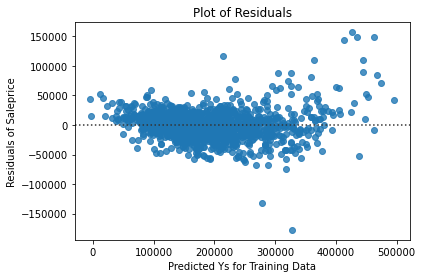

In [59]:
#Plot the residual plot for training data
figure = plt.figure()
sns.residplot(x=y_pred_train_lassocv, y = y_train).set(xlabel='Predicted Y value', 
                                                       ylabel='Residuals of Saleprice',
                                                       title = 'Plot of Residuals');

The residual plot tells us that the residuals are approximately normal with a mean of 0 and equal variance. This is less true as predictions get higher. There are some outliers, especially two around the 300,000 mark, and some between 400,000 to 500,000. 

The test set predictions had a higher Root Mean Square error, but all models performed about 3 times as well as the baseline model. This suggests that that model has a low bias, but has slightly higher variance as it may have overfitted on the training data. Future iterations of this model might want to further reduce the complexity of the model.

### 6.2 Predicting Prices and saving the production model to a csv

In [16]:
#Make new test set to grab Id column
test_set_id = pd.read_csv('../datasets/test.csv')

In [17]:
#Print the mean_squared_error score for each model. The lower the score the better


In [18]:
#Set the model predictions as a DataFrame
predicted_test_scores = pd.DataFrame(ames_lassocv_model.predict(ames_test_sfs))

In [19]:
#Rename the column name from 0 to SalePrice
predicted_test_scores.rename(columns = {0:'SalePrice'}, inplace=True)

In [20]:
#Set Id numbers to be the same
predicted_test_scores['Id'] = test_set_id['Id']

In [21]:
#Swap the column positions so Id is on the left and SalePrice is on the right
predicted_test_scores = predicted_test_scores.reindex(columns= ['Id', 'SalePrice'])

In [30]:
predicted_test_scores.to_csv('../datasets/predicted_scores.csv')

## 6.3 Interpreting models and explaining production model choice

All the 4 models listed above are regression models. The basic interpretation is that with every increase in an x, the response variable y will increase by coefficient beta times. 

#### Ridge and Lasso regression

Ridge and Lasso regressions are regressions that control for high variance in models, meaning that they control the amount of complexity the models have. They both do this by adding a penalty term to the basic linear regression equation. The difference between the two is how strongly this penalty term is weighted. Ridge regression takes the square of the penalty term, while Lasso simply takes the absolute value of the penalty term.

For practical purposes, you can think of Ridge and Lasso regressions as 'reducing the strength' of variable coefficients. For example, if one variable x has coefficient 10,000, both regressions might reduce the strength to about 1,000. The difference between Ridge and Lasso is **how much** and **how quickly** the coefficient size is reduced.

Ridge regression reduces linear regression coefficients gradually, with a steep decrease at the start and a tapered decrease later on. However, the coefficients will never disappear. They may be small, but **all the features used in Ridge regression will remain in the model**.

For Lasso regression, the decrease in coefficient size is very quick, almost linearly straight down. Coefficients can be set to 0, meaning that **some features will not be used in the model any longer**.

#### ElasticNet regression

ElasticNet is simply a mix of both Lasso and Ridge regressions, weighted with a lambda variable. If lambda=1, ElasticNet is using purely Lasso regression. If lambda=0, it's using purely Ridge regression. if lambda is anywhere between 0 and 1, it's using a mix of both regressions.

#### Choosing the production model

For my models above, the scores are around the same. This is not surprising as the best features were already selected by Sequential Feature Selector. ElasticNet did worse than either Lasso or Ridge on a default setting of 0.5 and only scored around the same as Ridge and Lasso regression. The optimal mix of Lasso and Ridge regressions, at 0.456, was still not as good as purely Lasso.

I will pick the Lasso regression model because it gives the same score as Linear Regression. While I could have picked Linear Regression, the fact is that linear regression gives the 'baseline' score. Lasso Regression is still slightly better.

Let's see the features and the coefficients

In [22]:
#Grab the coefficients for Lasso Regression, which gives a slightly better score than Linear and Ridge regression
best_lasso_coef = pd.DataFrame(data = [features_to_use, ames_lassocv_model.coef_])
best_lasso_coef.columns = best_lasso_coef.iloc[0]
best_lasso_coef.drop(best_lasso_coef.index[[0]], inplace=True)

In [76]:
best_lasso_coef.sort_values(by=1, axis=1, ascending=False)

,gr_liv_area,overall_qual,year_built,bsmtfin_sf_1,neighborhood_NridgHt,lot_area,sale_type_New,exter_qual,mas_vnr_area,bsmt_exposure,overall_cond,neighborhood_StoneBr,kitchen_qual,total_bsmt_sf,neighborhood_NoRidge,bsmt_qual,screen_porch,functional,condition_1_Norm,exterior_1st_BrkFace,neighborhood_Crawfor,roof_style_Hip,condition_2_PosA,land_contour_HLS,condition_1_PosN,neighborhood_BrkSide,garage_type_Attchd,bedroom_abvgr,mas_vnr_type_BrkFace,ms_subclass
1,30159.8,12542.5,10113.4,9784.84,7383.45,6453.41,6196.48,6069.91,5961.22,5532.54,5530.93,5509.17,5401.25,5185.52,4165.89,3934.69,3473.21,3182.21,2713.46,2553.95,2273.6,2235.78,2208.07,2142.96,1971.75,1707.06,-1991.53,-3776.64,-4317.12,-6023.33


## Section 7: Interpreting the Lasso Regression Model and Recommendations

### Most Important positive factors

**gr_liv_area, overall_qual, and year_built** seem to be the three strongest factors that affect housing prices. Simply increasing your above ground living area square feet by 1 increases the housing price by a wooping 30,172! Comparatively, overall_qual and year_built are about a third as strong, with an increase in overall quality by 1 signalling an increase by 12,532. Finally, every new year that arrives means that houses selling in that year are about 10,130 more expensive than the previous year!

**bsmtfin_sf_1** follows **year_built**, being just below the 10,000 mark. Type 1 finish is very important for housing, so you should use Type 1 housing if you're renovating a house for sale.

### Negative factors

**ms_subclass** is a numerical nominal class. It starts with 020 and ends with 190 with increments of 5 (e.g. 040 -> 045) or 10 (e.g. 020 -> 030). This tells us that the higher the number, the less valuable the house is. Meaning that 2 FAMILY CONVERSION - ALL STYLES AND AGES is less valuable than 1-STORY 1946 & NEWER ALL STYLES. An increase by 10 in this variable decreases value by 60,280 (multiplied by 10 since each increment is a multiple of 10)

**bedroom_abvgr**. 'abvgr' refers to a value in the discrete 'bedroom' category, refering to the number of bedrooms above ground. Apparently the more bedrooms you have above ground, the cheaper your house, by 3787. Perhaps because it is exposed to the noise of the streets, or because it's another signal for the fact that the house doesn't have bedrooms below ground.

**mas_vnr_type_BrkFace**. 'BrkFace' refers to the Brick Face masonry veneer type. If you have this type of veneer, your house value drops by 4330. Perhaps this is because Brick Face is a cheaper type of veneer.

**garage_type_Attchd**. Having a garage attached (Attchd) to your home means your house is cheaper by 2000. This sounds like it's a signal for how the house was built. In other words, only houses built a certain way will have a garage attached to them.

### Other factors

**neighbourhood_...** the elipses refers to the different types of neighborhoods the house can be located in. While none of the neighborhoods reduce prices, there are neighborhoods that can increase prices by as much as 5x with a baseline of around 1700. For example, compare BrkSide and NridgeHt, with BrkSide increasing prices by 1713 compared to NridgeHt's 7387.

**lot_area** is easily understood. As the size your house increases, prices increase too. lot_area contribute about half as much as the year_built!

**sale_type_new** means that a new home that's just constructed and sold brings in the most money. This is as expected because new homes are at their best condition.

**exter_qual** is our first ordinal value in this linear regression, meaning that excellent quality materials bring 5 times as much as poor material quality. This means that this factor can easily bring in as much money as ground living area!

### Conclusion

The rest of the factors, like 'other factors' above, are easy to interpret. In the end, the bigger the house, with a better rating of quality and condition, fetches you the highest prices. Even if you have the negative factors attached to the home, they only reduce prices by a factor of 1/5 or so (i.e. prices reduce by -6000 for every 30,000 increase in price, given ms_subclass and gr_liv_area). 

#### For Companies

For a given house, make sure that the quality and condition matches the one stated on paper. While it may be possible, though not advisable, to sell a BrkfacFace veneer at a more expensive price than expected, it's impossible to hide a house's quality and condition. If your company builds and sells property, you may want to build 1 story houses instead of 2 family conversions as it gives a better return of investment. However, watch out for market saturation: too many of the same type of house and the houses won't command as much money.

#### For Consumers

Location, location, location matters. Assuming you are someone most concerned with price, try to go for a cheaper neighborhood. But if you wish to stay at, say, NridgeHt, it's not the end of the world. Buy a more run down home and upgrade it yourself! Look for bedrooms above ground, and try to get a house that has a garage attached to it. Get an older house, not one built recently; the older the house the better. Make sure you don't buy a house with a basement. Get a house with a Brick Face veneer and renovate the house.

### Further Steps

With a linear regression model built for this town, perhaps building another linear regression model on a similar dataset for another town would be useful. With the two linear models, we can compare the coefficients and find out whether the same features play the biggest part in housing prices.

## References

(2020, July 17). _City Assessor_. City of Ames. [https://www.cityofames.org/government/departments-divisions-a-h/city-assessor](https://www.cityofames.org/government/departments-divisions-a-h/city-assessor)

Boachie, P. (2016, July 21). _5 Strategies of 'Psychological Pricing'_. The Entrepreneur. [https://www.entrepreneur.com/article/279464](https://www.entrepreneur.com/article/279464)

De Cock, D. _Ames Iowa: Alternative to the Boston Housing Data Set_. Truman State University. [http://jse.amstat.org/v19n3/decock/DataDocumentation.txt](http://jse.amstat.org/v19n3/decock/DataDocumentation.txt)

Kuhn, M. & Johnson, K. (2019, June 21). _Feature Engineering and Selection: A Practical Approach for Predictive Models_. Taylor & Francis Group. [https://bookdown.org/max/FES/](https://bookdown.org/max/FES/)